In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [3]:
def time_in_seconds(val):
    sec=0.0
    if "-" in val:
        fields = val.split("-")
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        if 'h' in val:
            fields = val.split("h")
            sec = 3600 * float(fields[0]) + 60 * float(fields[1].strip("m"))
            return sec
        elif 'm' in val:
            fields = val.split("m")
            sec = 60 * float(fields[0]) + float(fields[1].strip("s"))
            return sec
        else:
            return float(val.strip("s"))

In [4]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Routines:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [5]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [6]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, file_name='scaling.png'):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])

    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [7]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [12]:
scaling = build_dataframe(x_axis='mpi', factor=160)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  Time-Profile     io_WF  io_GROT  \
2    64    32     2048     16         1       12370.0   11.0839   0.0461   
1    80    32     2560     20         1       10506.0    9.1501   0.0439   
0   160    32     5120     40         1        6660.0    8.9924   0.0427   
9   240    32     7680     60         1        5276.0  254.3553   0.0457   
5   320    32    10240     80         1        3694.0    7.4927   0.0413   
7   400    32    12800    100         1        3182.0    9.4217   0.0414   
4   480    32    15360    120         1        2906.0    9.3863   0.0588   
3   600    32    19200    150         1        2447.0   11.5171   0.0449   
6   800    32    25600    200         1        2292.0   16.5867   0.0966   
8  1000    32    32000    250         1        1792.0   25.6227   0.0451   

   io_QINDX  io_COL_CUT  ...  XC_potential_driver   GW(ppa)  GW(REDUX)  \
2    0.0058      0.1698  ...               1.6199  222.9299     3.8108   
1    0.0052      0.1421  ...               1.3434  180.6698     4.7856   
0    0.0063      0.1179  ...               1.1267  109.5492     0.0418   
9    0.0054      0.1558  ...               0.9413   89.6504     0.1824   
5    0.0054      0.1749  ...               0.8408   69.8414     0.2873   
7    0.0057      0.1936  ...               0.8320   69.7022     0.0512   
4    0.0097      0.1667  ...               0.9525   59.4525     0.6409   
3    0.0075      0.1742  ...               0.8855   60.5440     0.7012   
6    0.0064      0.1918  ...               0.7408   61.2519     0.1023   
8    0.0057      0.2994  ...               0.8281   56.2033     0.2416   

   io_QP_and_GF  ideal   speedup  efficiency  Self energy     Other  \
2        0.0546   0.40  0.538399  134.599838     229.0500  201.0574   
1        0.0518   0.50  0.633923  126.784694     185.0356  206.4368   
0        0.0561   1.00  1.000000  100.000000     112.5612  286.6202   
9        0.0552   1.50  1.262320   84.154663      91.1837  449.7518   
5        0.0533   2.00  1.802924   90.146183      71.3991  157.4273   
7        0.0524   2.50  2.093023   83.720930      71.2022  173.9992   
4        0.0550   3.00  2.291810   76.393668      60.4827  239.3718   
3        0.0522   3.75  2.721700   72.578668      61.5717  191.7715   
6        0.0543   5.00  2.905759   58.115183      62.0518  505.1072   
8        0.0525   6.25  3.716518   59.464286      56.9648  240.3603   

       node_h  
2   54.977778  
1   58.366667  
0   74.000000  
9   87.933333  
5   82.088889  
7   88.388889  
4   96.866667  
3  101.958333  
6  127.333333  
8  124.444444  

[10 rows x 51 columns]

In [13]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile   Dipoles       Xo        X  Self energy     Other
2    64       12370.0  519.3141  11400.0  20.5785     229.0500  201.0574
1    80       10506.0  433.7678   9660.0  20.7598     185.0356  206.4368
0   160        6660.0  240.0139   6000.0  20.8047     112.5612  286.6202
9   240        5276.0  453.6740   4260.0  21.3905      91.1837  449.7518
5   320        3694.0  129.3379   3315.0  20.8357      71.3991  157.4273
7   400        3182.0  118.1328   2797.0  21.6658      71.2022  173.9992
4   480        2906.0  132.7815   2450.0  23.3640      60.4827  239.3718
3   600        2447.0   73.0557   2099.0  21.6011      61.5717  191.7715
6   800        2292.0   67.9403   1635.0  21.9007      62.0518  505.1072
8  1000        1792.0   58.7253   1414.0  21.9496      56.9648  240.3603

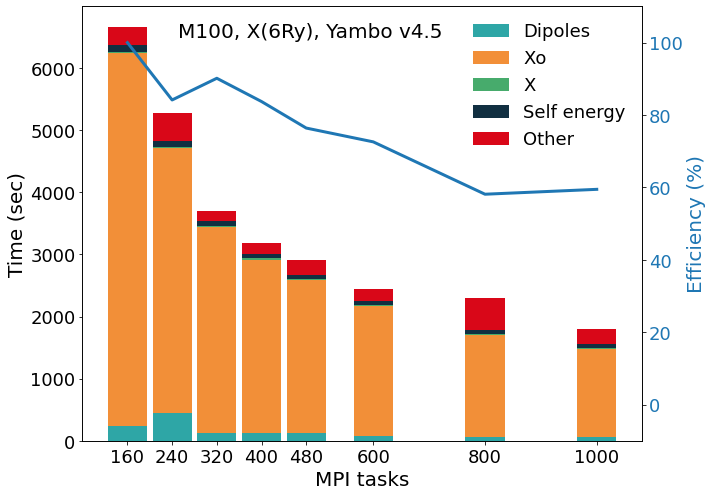

In [20]:
build_scaling_plot(scaling=scaling[scaling['mpi']>=160], pile=pile, colors=colors, bar_width=70, efficiency=True,
                   legend_loc='upper right', label=r'M100, X(6Ry), Yambo v4.5', label_pos=(250, 6500), file_name='scaling.png')

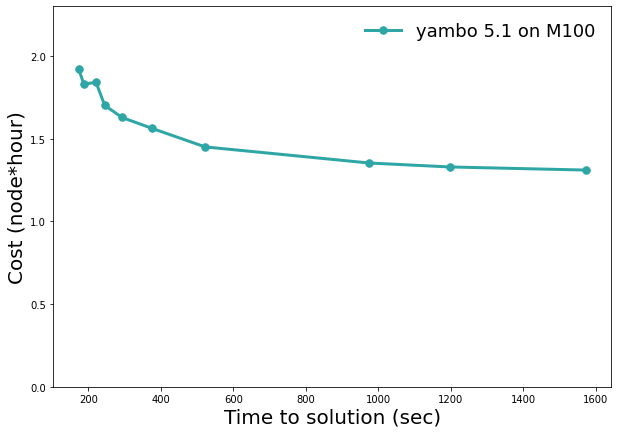

In [45]:
build_cost_plot(scaling=scaling, label='yambo 5.1 on M100', y_lim=[0,2.3])